# RNN 实现情感分类

## 一、准备工作
### 1、导入库

In [76]:
import string
import re
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as Data
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 2、导入数据

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv('/Users/liming/Downloads/review_star.csv')
print(data.shape)
data.head()

(10000, 3)


,reviewid,reviewbody,star
0,661655779,感谢大众点评的vip会员卷。很多好吃的都打折。去天河城吃饭顺便把喝的换了。两杯茶才9.9。简...,40
1,661662037,（9月26日就餐）这家的服务态度真是很奇葩了：在等餐时看到服务员在端豆浆上桌前，突然在碗里发...,5
2,661662167,除了贵 没毛病,35
3,661674219,亲民，家门口，味道可以，主要是在家附近，吃点家常菜还是比较方便的，不做饭就在这里吃点，做的也...,45
4,661677846,之前在会展中心店按过，觉得很不错，说上梅林也有一家店，刚好在附近办事，所以来了这里，装修风格...,50


### 3、数据预处理

数据预处理是比较关键的一部分，也是可以通用的一部分。数据预处理大致分为下面几个部分.

- 文本分词
- 剔除标点符号
- 建立 word2idx, idx2word, word2count(每个单词出现的次数), n_word(总的单词个数)
- 去掉一些低频的词汇(有时也会去掉停用词);
- 将句子转换为Tensor, 每个word使用index来进行代替;
- 对句子进行填充, 使每句句子的长度相同, 这样可以使用batch进行训练(需要确定最终句子的长度)
- 将label转换为one-hot的格式, 方便最后的训练(Pytorch中只需要转换为标号即可)

In [99]:
# 定义函数：根据用户评的星级来估计sentiment（情感）
def make_label(star):
    if star >=30:
        return 1
    else:
        return 0
# 运用 apply 方法得到新列
data["sentiment"] = data.star.apply(make_label)
data["reviewbody"] = data["reviewbody"].astype(str)
data.head()

,reviewid,reviewbody,star,sentiment,cut_comment
0,661655779,感谢大众点评的vip会员卷。很多好吃的都打折。去天河城吃饭顺便把喝的换了。两杯茶才9.9。简...,40,1,感谢 大众 点评 的 vip 会员 卷 很多 好吃 的 都 打折 去 天河城 吃饭 顺便...
1,661662037,（9月26日就餐）这家的服务态度真是很奇葩了：在等餐时看到服务员在端豆浆上桌前，突然在碗里发...,5,0,9 月 26 日 就餐 这家 的 服务态度 真是 很 奇葩 了 在 等 餐时 看到 服...
2,661662167,除了贵 没毛病,35,1,除了 贵 没 毛病
3,661674219,亲民，家门口，味道可以，主要是在家附近，吃点家常菜还是比较方便的，不做饭就在这里吃点，做的也...,45,1,亲民 家门口 味道 可以 主要 是 在家 附近 吃点 家常菜 还是 比较 方便 的 ...
4,661677846,之前在会展中心店按过，觉得很不错，说上梅林也有一家店，刚好在附近办事，所以来了这里，装修风格...,50,1,之前 在 会展中心 店 按 过 觉得 很 不错 说 上 梅林 也 有 一家 店 刚好 ...


In [89]:
# 首先对评论数据进行分词
import jieba

def chinese_word_cut(mytext):
    return " ".join(jieba.cut(mytext))

data['cut_comment'] = data["reviewbody"].apply(chinese_word_cut)
data.head()

,reviewid,reviewbody,star,sentiment,cut_comment
0,661655779,感谢大众点评的vip会员卷。很多好吃的都打折。去天河城吃饭顺便把喝的换了。两杯茶才9.9。简...,40,1,感谢 大众 点评 的 vip 会员 卷 。 很多 好吃 的 都 打折 。 去 天河城 吃饭 ...
1,661662037,（9月26日就餐）这家的服务态度真是很奇葩了：在等餐时看到服务员在端豆浆上桌前，突然在碗里发...,5,0,（ 9 月 26 日 就餐 ） 这家 的 服务态度 真是 很 奇葩 了 ： 在 等 餐时 看...
2,661662167,除了贵 没毛病,35,1,除了 贵 没 毛病
3,661674219,亲民，家门口，味道可以，主要是在家附近，吃点家常菜还是比较方便的，不做饭就在这里吃点，做的也...,45,1,亲民 ， 家门口 ， 味道 可以 ， 主要 是 在家 附近 ， 吃点 家常菜 还是 比较 方...
4,661677846,之前在会展中心店按过，觉得很不错，说上梅林也有一家店，刚好在附近办事，所以来了这里，装修风格...,50,1,之前 在 会展中心 店 按 过 ， 觉得 很 不错 ， 说 上 梅林 也 有 一家 店 ， ...


In [108]:
# 剔除标点符号
import re
punctuation = "[\.\：\～\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+"
re_punctuation = "[{}]+".format(punctuation)
def remove_symbol(sentence):
    return re.sub(punctuation,'', sentence)
data['cut_comment'] = data["cut_comment"].apply(remove_symbol)
data.head()

,reviewid,reviewbody,star,sentiment,cut_comment
0,661655779,感谢大众点评的vip会员卷。很多好吃的都打折。去天河城吃饭顺便把喝的换了。两杯茶才9.9。简...,40,1,感谢 大众 点评 的 vip 会员 卷 很多 好吃 的 都 打折 去 天河城 吃饭 顺便...
1,661662037,（9月26日就餐）这家的服务态度真是很奇葩了：在等餐时看到服务员在端豆浆上桌前，突然在碗里发...,5,0,9 月 26 日 就餐 这家 的 服务态度 真是 很 奇葩 了 在 等 餐时 看到 服...
2,661662167,除了贵 没毛病,35,1,除了 贵 没 毛病
3,661674219,亲民，家门口，味道可以，主要是在家附近，吃点家常菜还是比较方便的，不做饭就在这里吃点，做的也...,45,1,亲民 家门口 味道 可以 主要 是 在家 附近 吃点 家常菜 还是 比较 方便 的 ...
4,661677846,之前在会展中心店按过，觉得很不错，说上梅林也有一家店，刚好在附近办事，所以来了这里，装修风格...,50,1,之前 在 会展中心 店 按 过 觉得 很 不错 说 上 梅林 也 有 一家 店 刚好 ...


In [109]:
review = data[['cut_comment', 'sentiment']]
review.head()

,cut_comment,sentiment
0,感谢 大众 点评 的 vip 会员 卷 很多 好吃 的 都 打折 去 天河城 吃饭 顺便...,1
1,9 月 26 日 就餐 这家 的 服务态度 真是 很 奇葩 了 在 等 餐时 看到 服...,0
2,除了 贵 没 毛病,1
3,亲民 家门口 味道 可以 主要 是 在家 附近 吃点 家常菜 还是 比较 方便 的 ...,1
4,之前 在 会展中心 店 按 过 觉得 很 不错 说 上 梅林 也 有 一家 店 刚好 ...,1


In [110]:
# 数据预处理2：word2idx, idx2word, word2count(每个单词出现的次数), n_word(总的单词个数)
class Lang():
    
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        # 初始的时候SOS表示句子开头(0还在padding的时候会进行填充), EOS表示句子结尾(或是表示没有加入index中的新的单词, 即不常用的单词)
        self.index2word = {0:"SOS",1:"EOS"}
        self.n_words = 2
        
    def addSentence(self, sentence):
        # 把句子中的每个单词加入字典中
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words # 新单词的标号
            self.word2count[word] = 1 # 新单词的个数
            self.index2word[self.n_words] = word
            self.n_words = self.n_words + 1
        else:
            self.word2count[word] = self.word2count[word] + 1
            
# 把数据集中的每句话中的单词进行转化
lang = Lang()
for sentence_data in data["cut_comment"].values.tolist():
    # 增加word2index
    lang.addSentence(sentence_data)
# 显示一些统计数据
print("Count word:{}".format(lang.n_words))

Count word:38135


In [111]:
# 打印一下单词个数的分布
data_count = np.array(list(lang.word2count.values()))
# 有大量单词只出现了很少的次数
np.median(data_count), np.mean(data_count), np.max(data_count)

(1.0, 17.58744394618834, 116201)

In [112]:
# 计算<n的单词, 出现次数占总的出现次数的比例
less_count = 0
total_count = 0
for _,count in lang.word2count.items():
    if count < 2:
        less_count = less_count + count
    total_count = total_count + count
print("小于N的单词出现次数 : ",less_count,
      "\n总的单词出现次数 : ",total_count,
      "\n小于N的单词占比 : ",less_count/total_count*100)

小于N的单词出现次数 :  20583 
总的单词出现次数 :  670662 
小于N的单词占比 :  3.069057140556644


In [113]:
# 计算<n的单词, 出现个数占总的出现个数的比例
less_count = 0
total_count = 0
for _,count in lang.word2count.items():
    if count < 2:
        less_count = less_count + 1
    total_count = total_count + 1
print("小于N的单词出现个数 : ",less_count,
      "\n总的单词出现个数 : ",total_count,
      "\n小于N的单词占比 : ",less_count/total_count*100)

小于N的单词出现个数 :  20583 
总的单词出现个数 :  38133 
小于N的单词占比 :  53.97687042718905


In [114]:
# 我们设置单词至少出现2次
lang_process = Lang()
for word,count in lang.word2count.items():
    if count >= 2:
        lang_process.word2index[word] = lang_process.n_words # 新单词的标号
        lang_process.word2count[word] = count # 新单词的个数
        lang_process.index2word[lang_process.n_words] = word
        lang_process.n_words = lang_process.n_words + 1
# 显示一些统计数据
print("Count word:{}".format(lang_process.n_words))

Count word:17552


In [115]:
# 简单查看一下lang_process留下的单词
lang_process.word2count

{'感谢': 221,
 '大众': 325,
 '点评': 494,
 '的': 29766,
 'vip': 15,
 '会员': 81,
 '卷': 114,
 '': 116201,
 '很多': 1072,
 '好吃': 2758,
 '都': 4853,
 '打折': 56,
 '去': 2414,
 '天河城': 4,
 '吃饭': 306,
 '顺便': 53,
 '把': 364,
 '喝': 473,
 '换': 136,
 '了': 13021,
 '两杯': 32,
 '茶': 297,
 '才': 455,
 '99': 26,
 '简直': 133,
 '是': 7452,
 '太': 583,
 '合适': 126,
 '可以': 2691,
 '4': 183,
 '选': 267,
 '2': 281,
 '两款': 9,
 '奶茶': 282,
 '虽然': 372,
 '我选': 15,
 '但是': 1230,
 '确实': 237,
 '好喝': 292,
 '多': 1487,
 '包装': 41,
 '很': 9918,
 '有': 4007,
 '特色': 369,
 '服务员': 907,
 '热情': 616,
 '9': 86,
 '月': 143,
 '26': 20,
 '日': 39,
 '就餐': 62,
 '这家': 1332,
 '服务态度': 447,
 '真是': 207,
 '奇葩': 7,
 '在': 3572,
 '等': 608,
 '看到': 552,
 '端': 20,
 '豆浆': 52,
 '上': 1246,
 '桌前': 4,
 '突然': 60,
 '碗': 79,
 '里': 572,
 '发现': 287,
 '还': 3287,
 '过去': 179,
 '经理': 44,
 '然后': 400,
 '折': 65,
 '返回': 5,
 '后厨': 5,
 '处理': 56,
 '我': 4410,
 '特意': 85,
 '担心': 61,
 '问题': 154,
 '所以': 698,
 '马上': 73,
 '上前': 2,
 '说': 1343,
 '这': 751,
 '不要': 246,
 '换掉': 2,
 '吗': 164,
 '表示': 43,
 '

In [116]:
# 把data中的句子按顺序转为tensor
# 这里转换的时候,句子中的单词也是需要标准化的
def convertWord2index(word):
    if lang_process.word2index.get(word)==None:
        # 一些出现次数很少的词汇使用1来表示
        return 1
    else:
        return lang_process.word2index.get(word)
input_tensor = [[convertWord2index(s) for s in es.split(' ')]  for es in data["cut_comment"].values.tolist()]

In [117]:
# 查看最后两句话的文字
data["cut_comment"].values.tolist()[-2:]

[' 无锡 橙 v 有 特权  \\ \\ n  点评 首页 报名 霸王餐  一起 免费 吃喝玩乐  \\ \\ n 今天 和 小 助理 来 恒隆 喜茶 买 喝 的  买好 在 负 一楼 逛逛 街  看看 盲盒  走 着 走 着 快 到 星巴克 的 时候  发现 特斯拉 的 展览  远远 就 看到 有辆 特斯拉 的 车门 是 掀起 来 的  像 个 要 起飞 的 能源 车  \\ \\ n 特斯拉 专产 能源 车 的 牌子  车型 很漂亮  很 智能  我 和 朋友 都 喜欢 这个 车 的 中央 控制室 的 显示屏  超级 大  像 个 笔记本 的 显示器 挂 在 中间  好 霸气 [ 呲 牙 ]',
 'MUJI 一直 是 挑选 居家 用品 的 好去处  陪 女朋友 经常 去  各种 居家 用品 眼花缭乱  软软 的 沙发 忍不住 让 人 躺 上 一 躺   空气 中 弥漫着 空气 净化器 所 带来 的 微香  还有 很多 好玩 的 小玩样  零食 更是 不能 少  每次 带上 好 几包 回家 吃个 过瘾 ']

In [118]:
# 查看最后两句话的index
input_tensor[-2:]

[[9,
  4950,
  2728,
  2729,
  44,
  1337,
  9,
  106,
  106,
  107,
  9,
  4,
  1079,
  7332,
  592,
  9,
  353,
  633,
  6818,
  9,
  106,
  106,
  107,
  784,
  231,
  526,
  5712,
  173,
  8516,
  10610,
  939,
  19,
  5,
  9,
  15046,
  57,
  237,
  578,
  3586,
  1109,
  9,
  2235,
  1,
  9,
  240,
  713,
  240,
  713,
  1031,
  134,
  4161,
  5,
  471,
  9,
  67,
  17550,
  5,
  2980,
  9,
  8415,
  91,
  59,
  1,
  17550,
  5,
  1,
  27,
  1,
  173,
  5,
  9,
  911,
  729,
  593,
  1,
  5,
  17551,
  801,
  9,
  106,
  106,
  107,
  17550,
  1,
  17551,
  801,
  5,
  1153,
  9,
  1,
  1267,
  9,
  43,
  9707,
  9,
  76,
  231,
  245,
  12,
  447,
  123,
  801,
  5,
  432,
  1,
  5,
  11505,
  9,
  491,
  159,
  9,
  911,
  729,
  1,
  5,
  1,
  7400,
  57,
  1588,
  9,
  204,
  2463,
  233,
  1150,
  1151,
  235],
 [16239,
  333,
  27,
  6090,
  6742,
  2245,
  5,
  6895,
  9,
  3825,
  3738,
  194,
  14,
  9,
  213,
  6742,
  2245,
  9085,
  9,
  1564,
  5,
  5224,
  5518,
  3

In [119]:
# 查看句子的平均长度, 长度的中位数, 最长的长度
sentence_length = [len(t) for t in input_tensor]
print(np.mean(sentence_length))
print(np.median(sentence_length))
print(np.max(sentence_length))

67.0662
43.0
1184


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


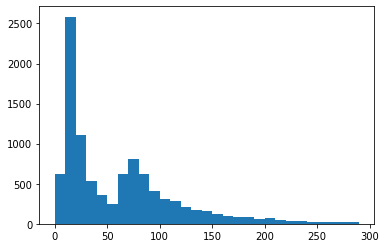

In [120]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bins = np.arange(0,300,10) # 产生区间刻度
ax.hist(sentence_length,bins=bins)
fig.show()

In [121]:
def pad_sequences(x, max_len):
    """定义自动填充的函数
    """
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len:
        padded[:] = x[:max_len]
    else:
        padded[:len(x)] = x
    return padded

In [122]:
input_tensor = [pad_sequences(x, 200) for x in input_tensor]
# 查看一下完成填充之后的数据
input_tensor[-2:]

[array([    9,  4950,  2728,  2729,    44,  1337,     9,   106,   106,
          107,     9,     4,  1079,  7332,   592,     9,   353,   633,
         6818,     9,   106,   106,   107,   784,   231,   526,  5712,
          173,  8516, 10610,   939,    19,     5,     9, 15046,    57,
          237,   578,  3586,  1109,     9,  2235,     1,     9,   240,
          713,   240,   713,  1031,   134,  4161,     5,   471,     9,
           67, 17550,     5,  2980,     9,  8415,    91,    59,     1,
        17550,     5,     1,    27,     1,   173,     5,     9,   911,
          729,   593,     1,     5, 17551,   801,     9,   106,   106,
          107, 17550,     1, 17551,   801,     5,  1153,     9,     1,
         1267,     9,    43,  9707,     9,    76,   231,   245,    12,
          447,   123,   801,     5,   432,     1,     5, 11505,     9,
          491,   159,     9,   911,   729,     1,     5,     1,  7400,
           57,  1588,     9,   204,  2463,   233,  1150,  1151,   235,
      

In [123]:
# 查看一下所有的分类
data['sentiment'].unique()

array([1, 0])

In [124]:
target_tensor = [s for s in data['sentiment'].values.tolist()]

# 简单查看一下样本
target_tensor[:10]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [125]:
# 数据集的划分(这里全部是训练集)
END = int(len(input_tensor)*0.9)
# 将数据转为tensor的数据格式
input_tensor_train = torch.from_numpy(np.array(input_tensor[:END]))
target_tensor_train = torch.from_numpy(np.array(target_tensor[:END])).long()
input_tensor_test = torch.from_numpy(np.array(input_tensor[END:]))
target_tensor_test = torch.from_numpy(np.array(target_tensor[END:])).long()
# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_test), len(target_tensor_test)

(9000, 9000, 1000, 1000)

In [126]:
# 加载dataloader
train_dataset = Data.TensorDataset(input_tensor_train, target_tensor_train) # 训练样本
test_dataset = Data.TensorDataset(input_tensor_test, target_tensor_test) # 测试样本
MINIBATCH_SIZE = 64
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=2           # set multi-work num read data
)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=2           # set multi-work num read data
)

## 模型构建

In [136]:
# GRU的model
class EmotionGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size, layers=2):
        super(EmotionGRU, self).__init__()
        self.vocab_size = vocab_size # 总的单词的个数
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.batch_sz = batch_sz
        self.output_size = output_size
        self.num_layers = layers
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim) # 可以将标号转为向量
        self.dropout = nn.Dropout(0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units, num_layers=self.num_layers, batch_first = True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(self.hidden_units*2, self.output_size)
    
    def init_hidden(self):
        # 使用了双向RNN, 所以num_layer*2
        return torch.zeros((self.num_layers*2, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self,x):
        self.batch_sz = x.size(0)
        # print(x.shape)
        x = self.embedding(x)
        # print(x.shape)
        self.hidden = self.init_hidden()
        output, self.hidden = self.gru(x, self.hidden)
        # print(output.shape)
        # 因为是 batch*seq*output, 所以要取最后一个seq
        output = output[:,-1,:]
        output = self.dropout(output)
        output = self.fc(output)
        # print(output.shape)
        return output
    
    
# LSTM的model
class EmotionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size, layers=2):
        super(EmotionLSTM, self).__init__()
        self.vocab_size = vocab_size # 总的单词的个数
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.batch_sz = batch_sz
        self.output_size = output_size
        self.num_layers = layers
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim) # 可以将标号转为向量
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_units, num_layers=self.num_layers, batch_first = True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(self.hidden_units*2, self.output_size)
        
    def init_hidden(self):
        # 使用了双向RNN, 所以num_layer*2
        return torch.zeros((self.num_layers*2, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self,x):
        self.batch_sz = x.size(0)
        # print(x.shape)
        x = self.embedding(x)
        # print(x.shape)
        self.hidden = self.init_hidden()
        output, self.hidden = self.lstm(x, self.hidden)
        # print(output.shape)
        # 因为是 batch*seq*output, 所以要取最后一个seq
        output = output[:,-1,:]
        output = self.dropout(output)
        output = self.fc(output)
        # print(output.shape)
        return output

In [137]:
# 测试模型
vocab_inp_size = len(lang_process.word2index)
embedding_dim = 256
hidden_units = 512
target_size = 2 # 一共有2种emotion
layers = 3
# 测试模型
model = EmotionGRU(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size, layers).to(device)
# 测试数据
it = iter(train_loader)
x, y = next(it)
output = model(x.to(device))
# 64*2, 表示一共有64个样本, 每个样本是2个emotion的概率
output.size()

torch.Size([64, 2])

In [138]:
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (logit == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [139]:
# 模型超参数
vocab_inp_size = len(lang_process.word2index)
embedding_dim = 256
hidden_units = 512
target_size = 2 # 一共有6种emotion
num_layers = [1,2,3]
for layers in num_layers:
    # 测试模型
    modelGRU = EmotionGRU(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size, layers).to(device)
    modelLSTM = EmotionLSTM(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size, layers).to(device)
    models = {'GRU':modelGRU, 'LSTM':modelLSTM}
    for key, model in models.items():
        # 定义损失函数和优化器
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(),lr=0.001)
        # 开始训练
        num_epochs = 25
        for epoch in range(num_epochs):
            start = time.time()
            train_total_loss = 0 # 记录一整个epoch中的平均loss
            train_total_accuracy = 0 # 记录一整个epoch中的平均accuracy
            ### Training
            for batch, (inp, targ) in enumerate(train_loader):
                predictions = model(inp.to(device))
                # 计算误差     
                loss = criterion(predictions, targ.to(device))
                # 反向传播, 修改weight
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # 记录Loss下降和准确率的提升
                batch_loss = (loss / int(targ.size(0))) # 记录一个bacth的loss      
                batch_accuracy = accuracy(predictions, targ.to(device))
                train_total_loss = train_total_loss + batch_loss
                train_total_accuracy = train_total_accuracy + batch_accuracy
                if batch % 25 == 0:
                    record_train_accuracy = train_total_accuracy.cpu().detach().numpy()/(batch+1)
                    print('Epoch {} Batch {} Accuracy {:.4f}. Loss {:.4f}'.format(epoch + 1,
                                                                 batch,
                                                                 train_total_accuracy.cpu().detach().numpy()/(batch+1),
                                                                 train_total_loss.cpu().detach().numpy()/(batch+1)))
            # 每一个epoch来计算在test上的准确率
            print('------------')
            model.eval()
            test_total_accuracy = 0
            for batch, (input_data, target_data) in enumerate(test_loader):
                predictions = model(input_data.to(device))
                batch_accuracy = accuracy(predictions, target_data.to(device))
                test_total_accuracy = test_total_accuracy + batch_accuracy
            print('Test : Lay {}, Model {}, Epoch {} Accuracy {:.4f}'.format(layers, key, epoch + 1, test_total_accuracy.cpu().detach().numpy()/(batch+1)))
            record_test_accuracy = test_total_accuracy.cpu().detach().numpy()/(batch+1)
            if epoch == num_epochs - 1:
                # 把最后一轮的结果写入文件
                with open('byr.txt','a') as file:
                    file.write('{},{},{:.4f},{:.4f}'.format(key,layers,record_train_accuracy,record_test_accuracy))
            print('============')

Epoch 1 Batch 0 Accuracy 67.1875. Loss 0.0100
Epoch 1 Batch 25 Accuracy 93.1490. Loss 0.0045
Epoch 1 Batch 50 Accuracy 94.0564. Loss 0.0039
Epoch 1 Batch 75 Accuracy 94.2845. Loss 0.0037
Epoch 1 Batch 100 Accuracy 94.4462. Loss 0.0036
Epoch 1 Batch 125 Accuracy 94.7049. Loss 0.0035
------------


RuntimeError: index out of range: Tried to access index 17550 out of table with 17549 rows. at /tmp/pip-req-build-sqyrlut3/aten/src/TH/generic/THTensorEvenMoreMath.cpp:418